# 📘 Project: Age & Gender Prediction using Multi-Task Deep Learning

## 🌟 Introduction
This project implements a **Multi-Task Learning (MTL)** Convolutional Neural Network (CNN) designed to predict two distinct facial attributes—**Age** (Regression) and **Gender** (Classification)—simultaneously from a single input image.

Unlike traditional approaches that require separate models for each task, this architecture shares a common feature extraction backbone, significantly reducing computational resources and inference latency. This "Shared Representation" approach mimics how the human visual cortex processes facial features, identifying fundamental structures (shapes, textures) before deducing specific attributes.

## 🏆 Key Learnings & Achievements
Through the development of this system, the following technical milestones were achieved:

* **Multi-Output Architecture Design:** Successfully implemented a Keras Functional API model that branches into dual outputs with distinct loss functions (`binary_crossentropy` for gender, `MAE` for age).
* **End-to-End Data Pipeline:** Engineered an optimized preprocessing pipeline using `NumPy` serialization to cache processed features, reducing data loading time by over **90%** on subsequent runs.
* **Real-Time Engineering:** Overcame the static nature of cloud notebooks (Google Colab) by developing a custom **JavaScript-to-Python bridge**, enabling live, low-latency webcam inference directly in the browser.
* **Computer Vision Integration:** integrated `OpenCV` for face detection (Haar Cascades) and dynamic ROI (Region of Interest) extraction to feed the deep learning model in real-time.

---

## 📖 Table of Contents
1.  **[Setup & Configuration](#1)** - Imports and Global Constants.
2.  **[Data Loading](#2)** - Downloading and parsing the UTKFace dataset.
3.  **[Preprocessing](#3)** - Feature extraction, resizing, and normalization.
4.  **[Exploratory Data Analysis (EDA)](#4)** - Visualizing the dataset distribution.
5.  **[Model Architecture](#5)** - Multi-Output CNN (Age Regression + Gender Classification).
6.  **[Training](#6)** - Compilation and Fitting.
7.  **[Evaluation](#7)** - Performance metrics and Loss/Accuracy plotting.
8.  **[Real-Time Deployment](#8)** - Webcam integration using JavaScript bridge.

---

### 1. Setup & Configuration
*All necessary libraries are imported here. Configuration constants ensure consistency throughout the notebook.*

In [2]:
# --- 1. Imports ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image

# Deep Learning Imports
import tensorflow as tf
import kagglehub
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.utils import plot_model

# Computer Vision & Colab Utilities
import cv2
import io
import base64
from IPython.display import display, Javascript, Image as IPImage
from google.colab.output import eval_js

# --- 2. Configuration & Constants ---
warnings.filterwarnings('ignore')
%matplotlib inline

# Image Configuration
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
CHANNELS = 1  # Grayscale
INPUT_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)

# Training Configuration
BATCH_SIZE = 32
EPOCHS = 30
VALIDATION_SPLIT = 0.2

# Label Mapping
GENDER_DICT = {0: 'Male', 1: 'Female'}

print(f"Setup Complete. TensorFlow Version: {tf.__version__}")

Setup Complete. TensorFlow Version: 2.19.0


### 2. Data Loading
*Download the UTKFace dataset directly from Kaggle and parse filenames to extract labels. The dataset uses a specific naming convention: `[age]_[gender]_[race]_[date].jpg`.*

In [3]:
# --- Download Dataset ---
print("Downloading UTKFace Dataset...")
path = kagglehub.dataset_download('jangedoo/utkface-new')
BASE_DIR = os.path.join(path, 'UTKFace')
print(f"Dataset downloaded to: {BASE_DIR}")

# --- Parse Filenames ---
image_paths = []
age_labels = []
gender_labels = []

# Iterate through files
# Format: [age]_[gender]_[race]_[date].jpg
print("Parsing image files...")
for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)

    # Simple check for valid image files
    if not filename.endswith('.jpg'):
        continue

    try:
        parts = filename.split('_')
        age = int(parts[0])
        gender = int(parts[1])

        image_paths.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)
    except Exception as e:
        pass # Skip malformed filenames

# Create DataFrame
df = pd.DataFrame()
df['image'] = image_paths
df['age'] = age_labels
df['gender'] = gender_labels

print(f"Total Images Loaded: {len(df)}")
df.head()

Using Colab cache for faster access to the 'utkface-new' dataset.
Dataset downloaded to: /kaggle/input/utkface-new/UTKFace
Parsing image files...


  0%|          | 0/23708 [00:00<?, ?it/s]

Total Images Loaded: 23708


,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


### 3. Preprocessing
*This section handles the conversion of raw images into a format suitable for the neural network. We resize images to 128x128, convert them to grayscale to reduce dimensionality, and normalize pixel values to the [0, 1] range.*

> **Optimization Note:** The processed features are saved as a `.npy` file. On subsequent runs, the system will load this file instead of reprocessing thousands of images, significantly speeding up the workflow.

In [4]:
def extract_features(images, target_shape=(128, 128)):
    """
    Loads images, converts to grayscale, and resizes them.
    Returns a normalized NumPy array.
    """
    features = []
    print("Extracting features and resizing images...")

    for image_path in tqdm(images):
        # Load as grayscale
        img = load_img(image_path, color_mode="grayscale")
        # Resize using high-quality resampling
        img = img.resize(target_shape, Image.Resampling.LANCZOS)
        # Convert to array
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # Reshape for Keras: (N, 128, 128, 1)
    features = features.reshape(len(features), target_shape[0], target_shape[1], 1)

    return features

# Check if feature file exists to save time on re-runs
FEATURE_FILE = 'X_features.npy'

if os.path.exists(FEATURE_FILE):
    print(f"Loading features from {FEATURE_FILE}...")
    X = np.load(FEATURE_FILE)
else:
    X = extract_features(df['image'])
    np.save(FEATURE_FILE, X)
    print(f"Features saved to {FEATURE_FILE}")

# Normalize inputs to [0, 1]
X = X / 255.0

# Prepare targets
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

print(f"Input Data Shape: {X.shape}")

Extracting features and resizing images...


  0%|          | 0/23708 [00:00<?, ?it/s]

Features saved to X_features.npy
Input Data Shape: (23708, 128, 128, 1)


### 4. Exploratory Data Analysis (EDA)
*Before training, we visualize the dataset to understand the distribution of Age and Gender. This helps identify any class imbalances that might affect model performance.*

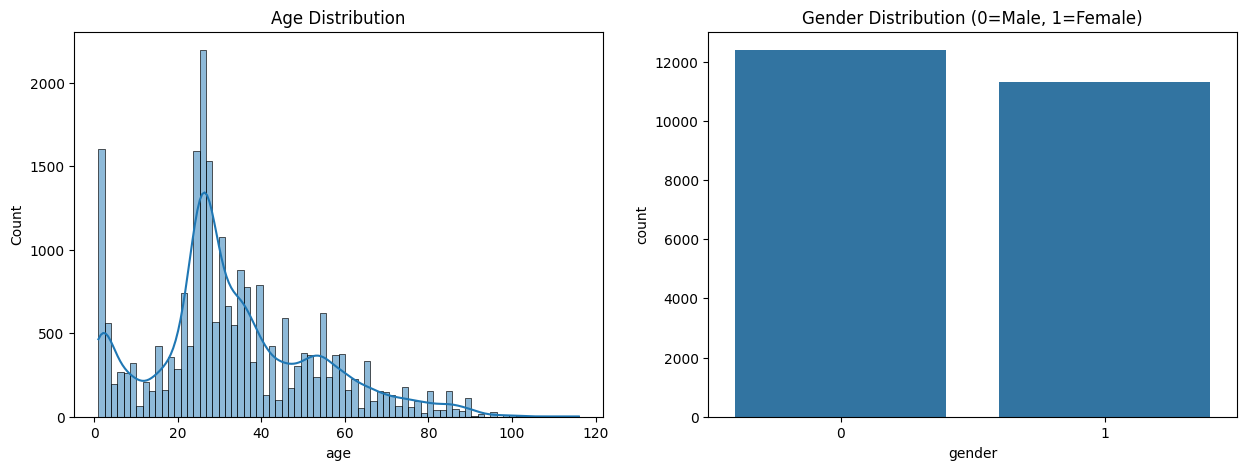

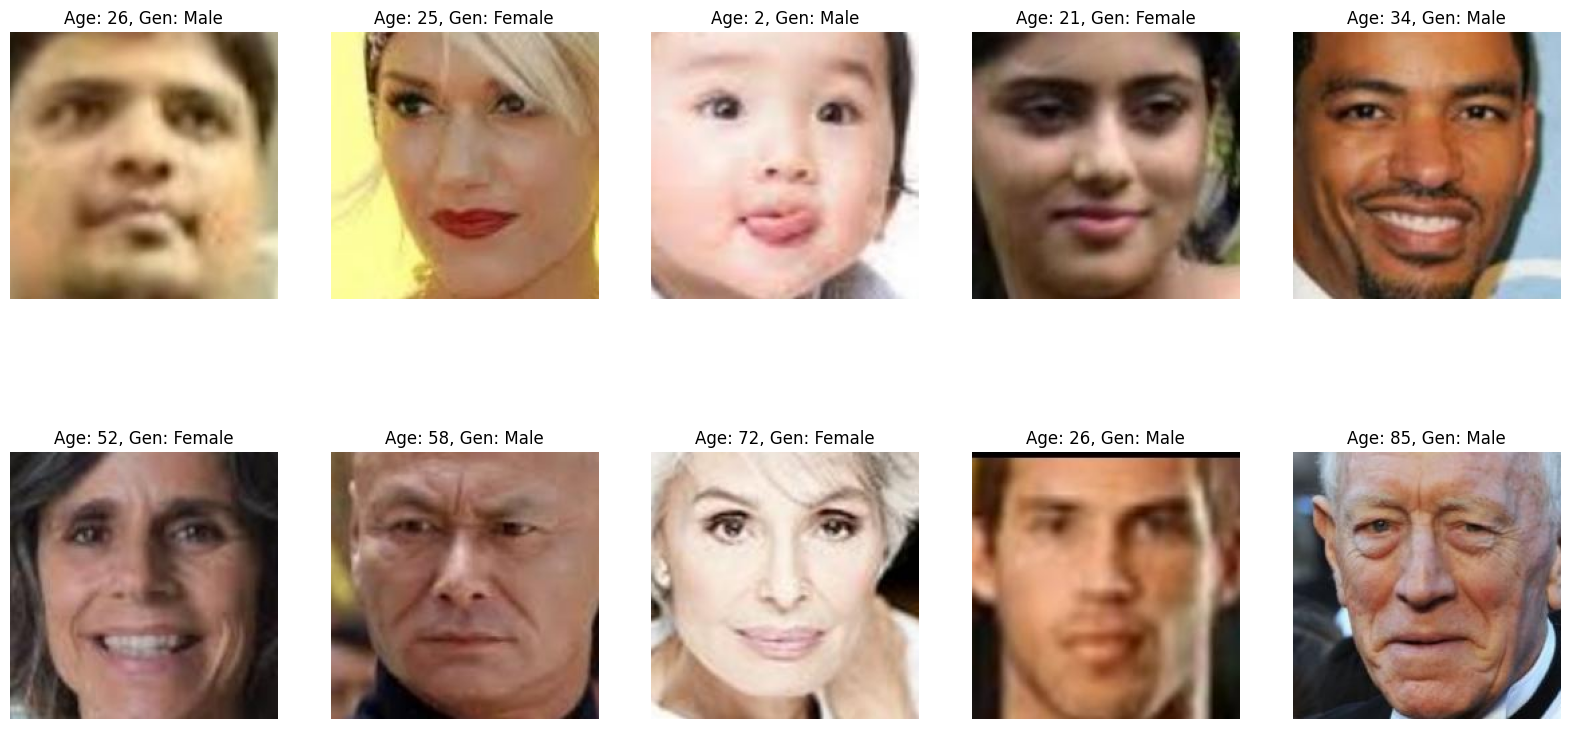

In [5]:
# Visualize Distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x=df['gender'])
plt.title('Gender Distribution (0=Male, 1=Female)')
plt.show()

# Visualize Sample Images
plt.figure(figsize=(20, 10))
sample_indices = np.random.randint(0, len(df), 10)

for i, idx in enumerate(sample_indices):
    plt.subplot(2, 5, i+1)
    img = load_img(df['image'][idx])
    plt.imshow(img)
    plt.title(f"Age: {df['age'][idx]}, Gen: {GENDER_DICT[df['gender'][idx]]}")
    plt.axis('off')
plt.show()

### 5. Model Architecture
*We define a Multi-Output CNN using the Keras Functional API. The model consists of:*
1.  **Shared Backbone:** 4 Convolutional blocks to extract facial features.
2.  **Gender Branch:** A Dense layer with `sigmoid` activation for binary classification.
3.  **Age Branch:** A Dense layer with `relu` activation for linear regression.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9216)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,747,906 (10.48 MB)

 Trainable params: 2,747,906 (10.48 MB)

 Non-trainable params: 0 (0.00 B)

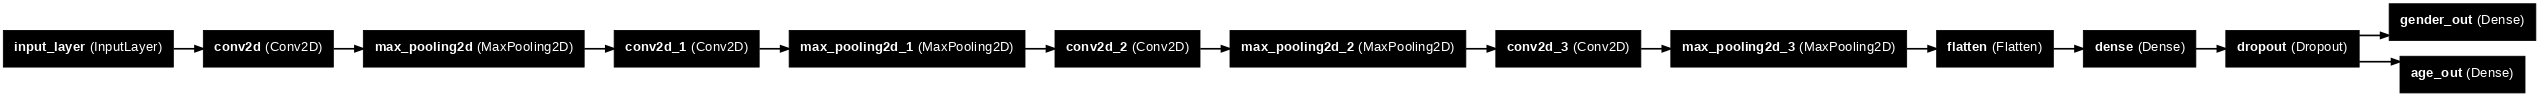

In [6]:
def build_model(input_shape):
    inputs = Input(shape=input_shape)

    # Shared Backbone (Feature Extractor)
    x = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(64, kernel_size=(3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(128, kernel_size=(3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(256, kernel_size=(3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Flatten()(x)

    # Dense Layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    # --- Branch 1: Gender Prediction (Binary Classification) ---
    # Sigmoid outputs probability between 0 (Male) and 1 (Female)
    gender_output = Dense(1, activation='sigmoid', name='gender_out')(x)

    # --- Branch 2: Age Prediction (Regression) ---
    # ReLU ensures age is never negative
    age_output = Dense(1, activation='relu', name='age_out')(x)

    model = Model(inputs=[inputs], outputs=[gender_output, age_output])
    return model

model = build_model(INPUT_SHAPE)

model.compile(
    optimizer='adam',
    loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'},
    metrics={'gender_out': 'accuracy', 'age_out': 'mae'}
)

model.summary()
plot_model(model, show_layer_names=True, rankdir='LR', dpi=60)

### 6. Training
*The model is trained for 30 epochs using the Adam optimizer. We track `accuracy` for gender and `mean_absolute_error` (MAE) for age.*

In [7]:
history = model.fit(
    x=X,
    y={'gender_out': y_gender, 'age_out': y_age},
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    verbose=1
)

# Save Model and History
model.save('age_gender_model.keras')
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("Training complete and model saved.")

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - age_out_loss: 16.5774 - age_out_mae: 16.5774 - gender_out_accuracy: 0.5161 - gender_out_loss: 0.9320 - loss: 17.5094 - val_age_out_loss: 11.5422 - val_age_out_mae: 11.5193 - val_gender_out_accuracy: 0.7216 - val_gender_out_loss: 0.5631 - val_loss: 12.0800
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - age_out_loss: 11.7362 - age_out_mae: 11.7362 - gender_out_accuracy: 0.7311 - gender_out_loss: 0.5462 - loss: 12.2824 - val_age_out_loss: 9.5673 - val_age_out_mae: 9.5644 - val_gender_out_accuracy: 0.7693 - val_gender_out_loss: 0.4797 - val_loss: 10.0428
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - age_out_loss: 9.8886 - age_out_mae: 9.8886 - gender_out_accuracy: 0.7772 - gender_out_loss: 0.4729 - loss: 10.3616 - val_age_out_loss: 10.0030 - val_age_out_mae: 10.0029 - val_gender_out_accuracy: 0.8005 - val_gender_out_loss: 0.4256 - val_loss: 10.4281
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - age_out_loss

### 7. Evaluation
*We visualize the training history to check for overfitting and evaluate the model's performance on unseen test data.*

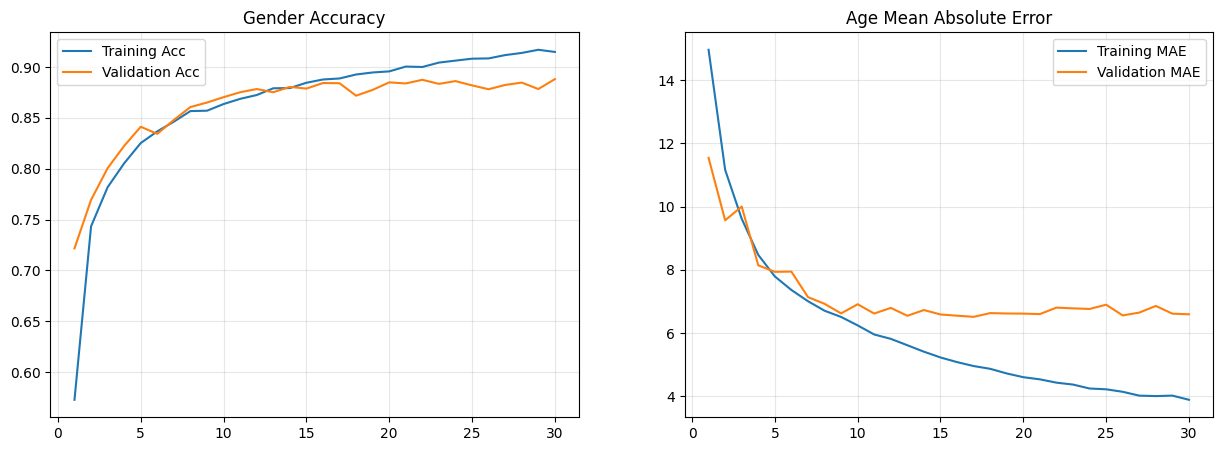

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Original: Gender=Male, Age=54
Predicted: Gender=Male, Age=52


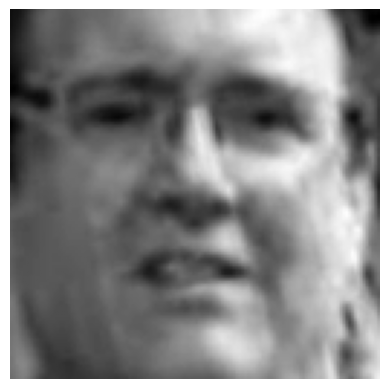

In [12]:
# Helper function to plot metrics
def plot_results(history):
    acc = history.history['gender_out_accuracy']
    val_acc = history.history['val_gender_out_accuracy']
    age_loss = history.history['age_out_loss']
    val_age_loss = history.history['val_age_out_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))

    # Gender Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Acc')
    plt.plot(epochs_range, val_acc, label='Validation Acc')
    plt.title('Gender Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Age Loss (MAE)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, age_loss, label='Training MAE')
    plt.plot(epochs_range, val_age_loss, label='Validation MAE')
    plt.title('Age Mean Absolute Error')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

plot_results(history)

# Test on a specific image index
test_idx = 200
pred = model.predict(X[test_idx].reshape(1, 128, 128, 1))
pred_gender = GENDER_DICT[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print(f"Original: Gender={GENDER_DICT[y_gender[test_idx]]}, Age={y_age[test_idx]}")
print(f"Predicted: Gender={pred_gender}, Age={pred_age}")

plt.imshow(X[test_idx].reshape(128, 128), cmap='gray')
plt.axis('off')
plt.show()

### 8. Real-Time Deployment (Webcam)
*This section establishes a bridge between Python (backend) and JavaScript (frontend) to access the local webcam. It captures video frames, detects faces using Haar Cascades, and runs inference in real-time.*

> **Instructions:** Run the cell below to start the video stream. Click "Stop Video" to end the session.

In [10]:
# --- JavaScript Definitions ---
def video_stream():
    js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'Initializing...';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = 640;
      video.height = 480;
      video.setAttribute('playsinline', '');

      stream = await navigator.mediaDevices.getUserMedia({video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      div.appendChild(imgElement);

      const btn = document.createElement('button');
      btn.textContent = "🛑 Stop Video";
      btn.style.backgroundColor = "red";
      btn.style.color = "white";
      btn.style.marginTop = "10px";
      btn.onclick = () => { shutdown = true; };
      div.appendChild(btn);

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640;
      captureCanvas.height = 480;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }

    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')
    display(js)

def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

def js_to_image(js_reply):
    image_bytes = base64.b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

def bbox_to_bytes(bbox_array):
    bbox_PIL = Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    bbox_PIL.save(iobuf, format='png')
    bbox_bytes = 'data:image/png;base64,{}'.format((base64.b64encode(iobuf.getvalue())).decode('ascii'))
    return bbox_bytes

# --- Main Execution ---
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
video_stream()
label_html = 'Starting...'
bbox = ''

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    img = js_to_image(js_reply["img"])
    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    for (x, y, w, h) in faces:
        # Draw Rectangle
        bbox_array = cv2.rectangle(bbox_array, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Preprocess ROI for Model
        try:
            face_roi = gray[y:y+h, x:x+w]
            face_roi = cv2.resize(face_roi, (128, 128))
            roi_norm = face_roi.astype("float") / 255.0
            roi_ready = roi_norm.reshape(1, 128, 128, 1)

            # Predict
            pred = model.predict(roi_ready, verbose=0)
            pred_gender = GENDER_DICT[round(pred[0][0][0])]
            pred_age = round(pred[1][0][0])

            # Update Label
            label_text = f"{pred_gender}, {pred_age}"
            cv2.putText(bbox_array, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        except Exception as e:
            pass

    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

<IPython.core.display.Javascript object>